<a href="https://colab.research.google.com/github/sooo19/A-study-of-the-data-generation-model-of-the-Folk-Painting-source-data/blob/main/FTiger_training_Resnet%2BTransformerDecoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Caption -> ResNet, TransformerDecoder


https://www.kaggle.com/dipanjandas96/image-caption-resnet-transformerdecoder-pytorch

1. Creating features for Images Using Resnet

2. Train Trnasformer Decoder Model which predicts next word given a sequence of tockens and Image Features from Step1

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random

pd.set_option('display.max_colwidth', None)

In [3]:
# read data
# "/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/Images"
# "/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/captions.txt",

df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/t10_archive/captions.txt', sep=',')
print(len(df))
display(df.head(3)) # 데이터가 제대로 읽어와졌는지 확인하기 위해, 상위 3개 caption 출력.
display(df.tail(3))


40505


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .


,image,caption
40502,t10.jpg,In folk paintings a tiger sits in front of a pine tree .
40503,t10.jpg,In folk paintings there is a yellow-eyed tiger in folk paintings .
40504,t10.jpg,In folk paintings there is a pine tree with green leaves in folk paintings .


#데이터 전처리
Single Character(단일 문자), non alpha word 제거, 토큰과 ',' 추가.
모든 캡션의 최대 길이(max_seq_len)는 33으로 맞춰진다.


In [4]:
def remove_single_char_word(word_list):
  lst=[]
  for word in word_list:
    if len(word)>1:
      lst.append(word)
  return lst

In [5]:
# <start> < > < > ... < > <end> 형태로 캡션 저장 => 최대 길이: 33
df['cleaned_caption']=df['caption'].apply(lambda caption : ['<start>']+[word.lower() if word.isalpha() else '' for word in caption.split(" ")]+['<end>'])

# single character 제거
df['cleaned_caption']=df['cleaned_caption'].apply(lambda x:remove_single_char_word(x))

# seq_len에 길이 저장 => 33
df['seq_len']=df['cleaned_caption'].apply(lambda x:len(x))
max_seq_len=df['seq_len'].max()
print(max_seq_len)

33


In [6]:
df.drop(['seq_len'], axis = 1, inplace=True)
df['cleaned_caption']=df['cleaned_caption'].apply(lambda caption: caption+['<pad>']*(max_seq_len-len(caption)))

# 상위 3개 데이터 예시 출력
display(df.head(3))

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[<start>, little, girl, climbing, into, wooden, playhouse, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


# Create Vocab and mapping of token to ID

In [7]:
word_list=df['cleaned_caption'].apply(lambda x: " ".join(x)).str.cat(sep=' ').split(' ')  
#join: , cat(concat): 문자열 합치기. sep=' '에 의해 한 칸씩 뛰고 저장이 된다.
word_dict=Counter(word_list)
word_dict=sorted(word_dict, key=word_dict.get, reverse=True)

print(len(word_dict))
print(word_dict[:20])

8366
['<pad>', '<start>', '<end>', 'in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two', 'white', 'black', 'boy', 'are', 'woman', 'girl', 'to']


In [8]:
vocab_size=len(word_dict)
print(vocab_size)

index_to_word = {index: word for index, word in enumerate(word_dict)} #enumerate: 반복문에서 index값(몇번째 요소인지)을 출력
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

8366
8366 8366


# Convert sequence of tokens to IDs

text_seq를 부여함. 단어별로 ID를 부여함.

In [9]:
df['text_seq']=df['cleaned_caption'].apply(lambda caption: [word_to_index[word] for word in caption])
display(df.head(3))

,image,caption,cleaned_caption,text_seq
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 41, 3, 89, 168, 6, 118, 52, 392, 11, 389, 3, 27, 5081, 692, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 18, 312, 63, 193, 116, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[<start>, little, girl, climbing, into, wooden, playhouse, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 39, 18, 118, 63, 193, 2406, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


# Split in Train and validation data. 
(Train과 validation data 나누기) 
한 데이터가 동시에 training, validation data가 될 수 없음.

In [10]:
df=df.sort_values(by='image')
train=df.iloc[:int(1.0*len(df))]  # train과 validation의 비율은 10:1
valid=df.iloc[int(0.0*len(df)):]

print(len(train), train['image'].nunique()) #nunique() : 데이터에 고유값들의 수를 출력, 즉 중복되는 않은 순 단어의 개수 세기
print(len(valid), valid['image'].nunique())

40505 8101
40505 8101


# Extract features from Images Using Resnet
Restnet 구조를 통해 feature 추출

In [11]:
train_samples=len(train)
print(train_samples)  # train 길이 출력

unq_train_imgs=train[['image']].drop_duplicates() #중복되는 이미지 제거
unq_valid_imgs = valid[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

40505
8101 8101


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) #Cuda 사용

cuda


In [13]:
class extractImageFeatureResNetDataSet(): # Resnet 구조를 이용해 이미지의 feature 값들을 추출
  def __init__(self, data):
    self.data=data
    self.scaler=transforms.Resize([224, 224]) # 이미지 크기 재정의
    self.normalize=transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    self.to_tensor=transforms.ToTensor()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image_name=self.data.iloc[idx]['image']
    img_loc="/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/t10_archive/Images/" + str(image_name)
    img=Image.open(img_loc)
    t_img=self.normalize(self.to_tensor(self.scaler(img)))
    return image_name, t_img

In [14]:
from torchvision import transforms

In [15]:
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_train_imgs)  # train 이미지들의 feature를 추출해 저장
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size=1, shuffle=False)

valid_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_valid_imgs)  # validation 이미지들의 feature를 추출해 저장
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [16]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [17]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

In [18]:
def get_vector(t_img):
  t_img = Variable(t_img)
  my_embedding = torch.zeros(1, 512, 7, 7)  # torch.zeros : 0으로 채워진 텐서 생성
  def copy_data(m, i, o):
    my_embedding.copy_(o.data)

  h = resNet18Layer4.register_forward_hook(copy_data)
  resnet18(t_img)

  h.remove()
  return my_embedding

In [19]:
#print("/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/Images/1000268201_693b08cb0e.jpg")

In [20]:
extract_imgFtr_ResNet_train = {}  # train 이미지들의 feature 추출
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):   # tqdm: 진행률 프로그래스바
  t_img = t_img.to(device)
  embdg = get_vector(t_img)

  extract_imgFtr_ResNet_train[image_name[0]] = embdg

  0%|          | 0/8101 [00:00<?, ?it/s]

In [21]:
a_file = open("./EncodedImageTrainResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [22]:
#t_image = Image.open(image_name).convert('RGB')

In [23]:
extract_imgFtr_ResNet_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
  t_img = t_img.to(device)
  embdg = get_vector(t_img)
  extract_imgFtr_ResNet_valid[image_name[0]] = embdg

  0%|          | 0/8101 [00:00<?, ?it/s]

In [24]:
a_file=open("./EncodedImageValidResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

#Create DataLoader which will be used to load data into Transformer Model
Transformer 모델에 데이터를 load하는데 사용할 dataloader을 생성

(FlickerDataSetResnet will return caption sequence, 1 timestep left shifted caption sequence which model will predict and Stored Image features from ResNet.)

In [25]:
global image_tensor_view

class FlickerDataSetResnet():
  def __init__(self, data, pkl_file):
    self.data=data
    self.encodedImgs = pd.read_pickle(pkl_file)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    caption_seq = self.data.iloc[idx]['text_seq']
    target_seq = caption_seq[1:]+[0]

    image_name = self.data.iloc[idx]['image']
    image_tensor = self.encodedImgs[image_name]
    image_tensor = image_tensor.permute(0,2,3,1)  # tensor의 모양을 변환. permute는 모든 차원을 교환할 수 있음.
    image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))
    return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [26]:
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [27]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageValidResNet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle = True)

#Create Transformer Decoder Model
This model will take caption sequence and the extracted resnet image features as input and output 1 timestep shifted caption sequence.

In the Transformer decoder, lookAhead and padding mask has also been applied

In [28]:
# Position Embedding

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

In [29]:
# Image Captioning Model
# Transformer Decoder

class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)
        

        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)
        

        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        

        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask

#Train the Model

The cross entropy loss has been masked at time steps where input token is <'pad'>.

In [30]:
EPOCH = 30
#EPOCH = 150

In [31]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose=True)
criterion=torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss=np.float('Inf')

In [32]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:
        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)

 
    total_epoch_train_loss = total_epoch_train_loss/total_train_words
  

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words
  
    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )
  
    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel')
        min_val_loss = total_epoch_valid_loss
  

    scheduler.step(total_epoch_valid_loss.item())

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch ->  0  Training Loss ->  5.2715935707092285 Eval Loss ->  4.353586673736572
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  4.1960320472717285 Eval Loss ->  3.917356491088867
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  3.881235122680664 Eval Loss ->  3.672017812728882
Writing Model at epoch  2
Epoch ->  3  Training Loss ->  3.686093330383301 Eval Loss ->  3.5016801357269287
Writing Model at epoch  3
Epoch ->  4  Training Loss ->  3.5424695014953613 Eval Loss ->  3.371613025665283
Writing Model at epoch  4
Epoch ->  5  Training Loss ->  3.4272074699401855 Eval Loss ->  3.2643659114837646
Writing Model at epoch  5
Epoch ->  6  Training Loss ->  3.328941822052002 Eval Loss ->  3.171278238296509
Writing Model at epoch  6
Epoch ->  7  Training Loss ->  3.246095657348633 Eval Loss ->  3.0873172283172607
Writing Model at epoch  7
Epoch ->  8  Training Loss ->  3.170769453048706 Eval Loss ->  3.013570785522461
Writing Model at epoch  8
Epoch ->  9  Training Loss -> 

#Generate Captions

In [33]:
model = torch.load('./BestModel')
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 33
print(start_token, end_token, pad_token)

1 2 0


In [34]:
valid_img_embed = pd.read_pickle('EncodedImageValidResNet.pkl')

In [54]:
def generate_caption(K, img_nm): 
    img_loc = '/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/t10_archive/Images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval() 
    valid_img_df = valid[valid['image']==img_nm]
    print("Actual Caption : ")
    print(valid_img_df['caption'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

#Test print

Actual Caption : 
['In folk paintings tigers have stripes and dot patterns .', 'In folk paintings a magpie sits on a pine tree .', 'In folk paintings a magpie is flying in a folktale .', 'In folk paintings a tiger sits on the grass .', 'There is one tiger and two magpies in folk paintings .']


Predicted caption : 
in folk paintings magpie is sitting on the ground .


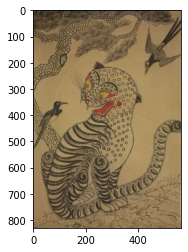

In [56]:
generate_caption(1, unq_train_imgs.iloc[-1]['image'])

Actual Caption : 
['A black and white dog is attempting to catch a yellow and purple object in a low cut yard .', 'A black and white dog jumps after a yellow toy .', 'a black and white dog jumps to get the Frisbee .', 'A black dog is jumping up to catch a purple and green toy .', 'A dog jumps to catch a toy .']


Predicted caption : 
black and white dog is running on the grass .


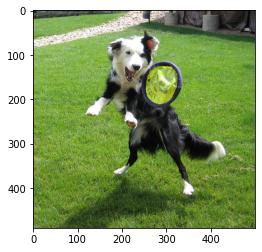

In [55]:
generate_caption(1, unq_valid_imgs.iloc[50]['image'])

#Tiger folk paintings
호랑이 민화 10장(t1.jpg~t10.jpg)에 대한 예측 캡션 생성

Actual Caption : 
['In folk paintings tigers have stripes and dot patterns .', 'In folk paintings a magpie sits on a pine tree .', 'In folk paintings a magpie is flying in a folktale .', 'In folk paintings a tiger sits on the grass .', 'There is one tiger and two magpies in folk paintings .']


Predicted caption : 
in folk paintings magpie is sitting on the ground .
Actual Caption : 
['In folk paintings tigers have stripes and dot patterns .', 'In folk paintings a magpie sits on a pine tree .', 'In folk paintings a magpie is flying in a folktale .', 'In folk paintings a tiger sits on the grass .', 'There is one tiger and two magpies in folk paintings .']


Predicted caption : 
in folk paintings magpie sits on the ground .
Actual Caption : 
['In folk paintings tigers have stripes and dot patterns .', 'In folk paintings a magpie sits on a pine tree .', 'In folk paintings a magpie is flying in a folktale .', 'In folk paintings a tiger sits on the grass .', 'There is one tiger and two magp

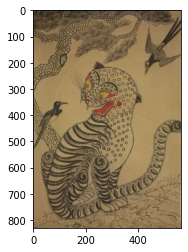

In [57]:
for i in range(1, 6):
  generate_caption(i, unq_train_imgs.iloc[-1]['image'])

Actual Caption : 
['In folk paintings a child tiger is standing on the ground .', 'There is a pine tree in folk paintings .', 'In folk paintings a child tiger is riding on an adult tiger .', 'There is one adult tiger and three child tigers in folk paintings .', 'In folk paintings a baby tiger sits on the ground .']


Predicted caption : 
in folk paintings there is tiger with pine tree .
Actual Caption : 
['In folk paintings a child tiger is standing on the ground .', 'There is a pine tree in folk paintings .', 'In folk paintings a child tiger is riding on an adult tiger .', 'There is one adult tiger and three child tigers in folk paintings .', 'In folk paintings a baby tiger sits on the ground .']


Predicted caption : 
in folk paintings there is pine tiger .
Actual Caption : 
['In folk paintings a child tiger is standing on the ground .', 'There is a pine tree in folk paintings .', 'In folk paintings a child tiger is riding on an adult tiger .', 'There is one adult tiger and three chi

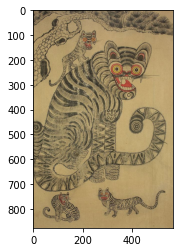

In [58]:
for i in range(1, 6):
  generate_caption(i, unq_train_imgs.iloc[-2]['image'])

Actual Caption : 
['In folk paintings one tiger has stripes and the other tiger has dot patterns .', 'Two adult tigers stand in folk paintings .', 'There are blue flowers and pink buds in folk paintings .', 'In folk paintings two tigers stand back and forth .', 'In folk paintings leaves hang on flowers .']


Predicted caption : 
there is tiger with green hair and black tiger is in folk paintings .
Actual Caption : 
['In folk paintings one tiger has stripes and the other tiger has dot patterns .', 'Two adult tigers stand in folk paintings .', 'There are blue flowers and pink buds in folk paintings .', 'In folk paintings two tigers stand back and forth .', 'In folk paintings leaves hang on flowers .']


Predicted caption : 
there are three children in folk paintings with green flowers and brown hair in folk paintings in the foreground .
Actual Caption : 
['In folk paintings one tiger has stripes and the other tiger has dot patterns .', 'Two adult tigers stand in folk paintings .', 'There

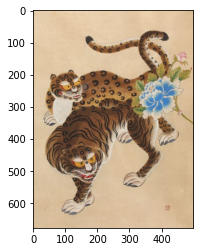

In [59]:
for i in range(1, 6):
  generate_caption(i, unq_train_imgs.iloc[-3]['image'])

Actual Caption : 
['In folk paintings there is a tiger family in the flower garden .', 'In folk paintings a family of tigers is among the flowers .', 'There are yellow flowers and white flowers in the flower garden in folk paintings .', 'In folk paintings there are an adult tiger and three child tigers among the flowers .', 'In folk paintings there is a brown tiger with black stripes .']


Predicted caption : 
in folk paintings there is tiger in folk paintings .
Actual Caption : 
['In folk paintings there is a tiger family in the flower garden .', 'In folk paintings a family of tigers is among the flowers .', 'There are yellow flowers and white flowers in the flower garden in folk paintings .', 'In folk paintings there are an adult tiger and three child tigers among the flowers .', 'In folk paintings there is a brown tiger with black stripes .']


Predicted caption : 
in folk paintings there is tiger with the flowers in her hand of the air and flowers .
Actual Caption : 
['In folk pain

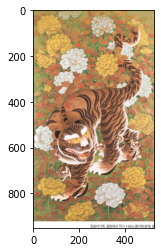

In [60]:
for i in range(1, 6):
  generate_caption(i, unq_train_imgs.iloc[-4]['image'])

Actual Caption : 
['There are two magpies and one tiger in folk paintings .', 'In folk paintings a yellow tiger with a black pattern is sitting .', 'In folk paintings a tiger sits in front of a pine tree .', 'In folk paintings two magpies sit on one pine tree .', 'In folk paintings there is green grass and red flowers along the road .']


Predicted caption : 
in folk paintings there is tiger with pine tree .
Actual Caption : 
['There are two magpies and one tiger in folk paintings .', 'In folk paintings a yellow tiger with a black pattern is sitting .', 'In folk paintings a tiger sits in front of a pine tree .', 'In folk paintings two magpies sit on one pine tree .', 'In folk paintings there is green grass and red flowers along the road .']


Predicted caption : 
there are one in white and green and brown and white tiger is in folk paintings with green tiger in the background and green folk .
Actual Caption : 
['There are two magpies and one tiger in folk paintings .', 'In folk paintin

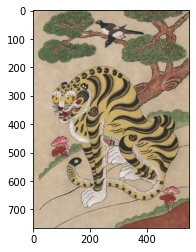

In [61]:
for i in range(1, 6):
  generate_caption(i, unq_train_imgs.iloc[-5]['image'])

Actual Caption : 
['There are two magpies and one tiger in folk paintings .', 'In folk paintings a patterned tiger is sitting on the grass .', 'In folk paintings a tiger sits in front of a pine tree .', 'In folk paintings there is a magpie sitting on a pine tree .', 'In folk paintings a magpie is flying .']


Predicted caption : 
there is pine tree in folk paintings .
Actual Caption : 
['There are two magpies and one tiger in folk paintings .', 'In folk paintings a patterned tiger is sitting on the grass .', 'In folk paintings a tiger sits in front of a pine tree .', 'In folk paintings there is a magpie sitting on a pine tree .', 'In folk paintings a magpie is flying .']


Predicted caption : 
there is one girl with green shirt on the ground .
Actual Caption : 
['There are two magpies and one tiger in folk paintings .', 'In folk paintings a patterned tiger is sitting on the grass .', 'In folk paintings a tiger sits in front of a pine tree .', 'In folk paintings there is a magpie sittin

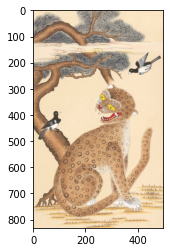

In [62]:
for i in range(1, 6):
  generate_caption(i, unq_train_imgs.iloc[-6]['image'])

Actual Caption : 
['There is a tiger with a pattern in folk paintings .', 'In folk paintings there is one pine tree .', 'In folk paintings there is a pine tree behind one tiger .', 'In folk paintings a magpie is sitting on a pine tree .', 'In folk paintings a patterned tiger is standing on the ground .']


Predicted caption : 
in folk paintings there is pine tree .
Actual Caption : 
['There is a tiger with a pattern in folk paintings .', 'In folk paintings there is one pine tree .', 'In folk paintings there is a pine tree behind one tiger .', 'In folk paintings a magpie is sitting on a pine tree .', 'In folk paintings a patterned tiger is standing on the ground .']


Predicted caption : 
in black and white tiger folk tiger .
Actual Caption : 
['There is a tiger with a pattern in folk paintings .', 'In folk paintings there is one pine tree .', 'In folk paintings there is a pine tree behind one tiger .', 'In folk paintings a magpie is sitting on a pine tree .', 'In folk paintings a patte

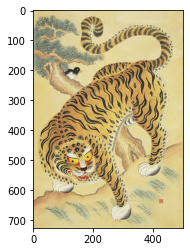

In [63]:
for i in range(1, 6):
  generate_caption(i, unq_train_imgs.iloc[-7]['image'])

Actual Caption : 
['There is a tiger in folk paintings .', 'In folk paintings there is a tiger with a pattern .', 'In folk paintings there is one pine tree .', 'In folk paintings there is a tiger next to the pine tree .', 'In folk paintings a tiger is coming down from a rock .']


Predicted caption : 
in folk paintings there is tiger with the sun in the background .
Actual Caption : 
['There is a tiger in folk paintings .', 'In folk paintings there is a tiger with a pattern .', 'In folk paintings there is one pine tree .', 'In folk paintings there is a tiger next to the pine tree .', 'In folk paintings a tiger is coming down from a rock .']


Predicted caption : 
there is an adult is tiger in front and some tigers .
Actual Caption : 
['There is a tiger in folk paintings .', 'In folk paintings there is a tiger with a pattern .', 'In folk paintings there is one pine tree .', 'In folk paintings there is a tiger next to the pine tree .', 'In folk paintings a tiger is coming down from a roc

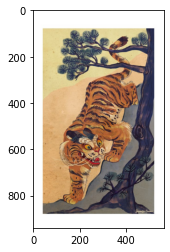

In [64]:
for i in range(1, 6):
  generate_caption(i, unq_train_imgs.iloc[-8]['image'])

Actual Caption : 
['In folk paintings there is a pine tree in folk paintings .', 'In folk paintings a tiger sits in front of a pine tree .', 'There is a brown tiger with a long tail in folk paintings .', 'In folk paintings there is a yellow-eyed tiger in folk paintings .', 'In folk paintings there is a pine tree with green leaves in folk paintings .']


Predicted caption : 
in folk paintings there is tiger with pine tree .
Actual Caption : 
['In folk paintings there is a pine tree in folk paintings .', 'In folk paintings a tiger sits in front of a pine tree .', 'There is a brown tiger with a long tail in folk paintings .', 'In folk paintings there is a yellow-eyed tiger in folk paintings .', 'In folk paintings there is a pine tree with green leaves in folk paintings .']


Predicted caption : 
there is tiger with tiger in folk folk .
Actual Caption : 
['In folk paintings there is a pine tree in folk paintings .', 'In folk paintings a tiger sits in front of a pine tree .', 'There is a br

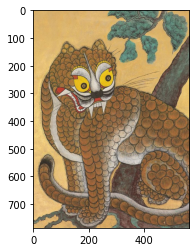

In [65]:
for i in range(1, 6):
  generate_caption(i, unq_train_imgs.iloc[-9]['image'])

Actual Caption : 
['There are two tigers with black patterns in folk paintings .', 'In folk paintings there are two tigers and two magpies .', 'In folk paintings one tiger is lying down and the other is standing .', 'In folk paintings two magpies are sitting on a branch .', 'In folk paintings two magpies are sitting on a pine tree .']


Predicted caption : 
in folk paintings there is tiger in folk paintings .
Actual Caption : 
['There are two tigers with black patterns in folk paintings .', 'In folk paintings there are two tigers and two magpies .', 'In folk paintings one tiger is lying down and the other is standing .', 'In folk paintings two magpies are sitting on a branch .', 'In folk paintings two magpies are sitting on a pine tree .']


Predicted caption : 
there are two tigers with tiger and folk paintings in front .
Actual Caption : 
['There are two tigers with black patterns in folk paintings .', 'In folk paintings there are two tigers and two magpies .', 'In folk paintings one

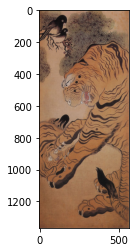

In [66]:
for i in range(1, 6):
  generate_caption(i, unq_train_imgs.iloc[-10]['image'])

#Non tiger folk paintings

Actual Caption : 
['A man in a pink shirt climbs a rock face', 'A man is rock climbing high in the air .', 'A person in a red shirt climbing up a rock face covered in assist handles .', 'A rock climber in a red shirt .', 'A rock climber practices on a rock climbing wall .']


Predicted caption : 
man is rock climbing .
Actual Caption : 
['A man in a pink shirt climbs a rock face', 'A man is rock climbing high in the air .', 'A person in a red shirt climbing up a rock face covered in assist handles .', 'A rock climber in a red shirt .', 'A rock climber practices on a rock climbing wall .']


Predicted caption : 
rock climber climbing .
Actual Caption : 
['A man in a pink shirt climbs a rock face', 'A man is rock climbing high in the air .', 'A person in a red shirt climbing up a rock face covered in assist handles .', 'A rock climber in a red shirt .', 'A rock climber practices on a rock climbing wall .']


Predicted caption : 
person in red jacket climbs rock face while another man loo

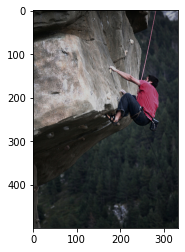

In [67]:
for i in range(1, 6):
  generate_caption(i, unq_train_imgs.iloc[-11]['image'])

Actual Caption : 
['Two dogs on pavement moving toward each other .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .']


Predicted caption : 
two dogs are playing with each other on the sidewalk .
Actual Caption : 
['Two dogs on pavement moving toward each other .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .']


Predicted caption : 
two black dogs are fighting on white and one brown dog in front of the other .
Actual Caption : 
['Two dogs on pavement moving toward each other .', 'A black dog and a white dog with brown spots are st

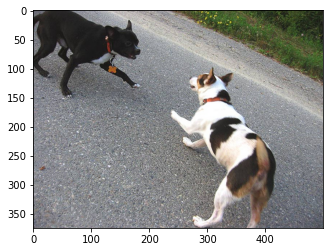

In [69]:
for i in range(1, 6):
  generate_caption(i, unq_train_imgs.iloc[1]['image'])

Actual Caption : 
['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


Predicted caption : 
little girl in pink shirt is sitting on wooden bench in front of wooden building .
Actual Caption : 
['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


Predicted caption : 
girl is standing outside of wooden house .
Actual Caption : 
['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the st

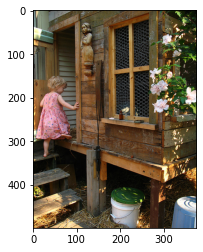

In [70]:
for i in range(1, 6):
  generate_caption(i, unq_train_imgs.iloc[0]['image'])

Actual Caption : 
['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pigtails sitting in front of a rainbow painting .', 'Young girl with pigtails painting outside in the grass .']


Predicted caption : 
little girl in pink is sitting on the grass with her arms raised .
Actual Caption : 
['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pigtails sitting in front of a rainbow painting .', 'Young girl with pigtails painting outside in the grass .']


Predicted caption : 
young girl is running through an obstacle course .


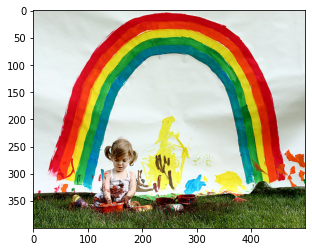

In [71]:
for i in range(1, 6):
  generate_caption(i, unq_train_imgs.iloc[2]['image'])

Actual Caption : 
['man laying on bench holding leash of dog sitting on ground', 'a man sleeping on a bench outside with a white and black dog sitting next to him .', 'A shirtless man lies on a park bench with his dog .', 'A man lays on a bench while his dog sits by him .', 'A man lays on the bench to which a white dog is also tied .']


Predicted caption : 
man with black and white dog is sitting on bench .
Actual Caption : 
['man laying on bench holding leash of dog sitting on ground', 'a man sleeping on a bench outside with a white and black dog sitting next to him .', 'A shirtless man lies on a park bench with his dog .', 'A man lays on a bench while his dog sits by him .', 'A man lays on the bench to which a white dog is also tied .']


Predicted caption : 
man with black hat and white dog on bench .
Actual Caption : 
['man laying on bench holding leash of dog sitting on ground', 'a man sleeping on a bench outside with a white and black dog sitting next to him .', 'A shirtless man

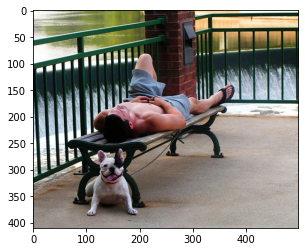

In [72]:
for i in range(1, 6):
  generate_caption(i, unq_train_imgs.iloc[3]['image'])

Actual Caption : 
['A man in an orange hat starring at something .', 'A man wears an orange hat and glasses .', 'A man with gauges and glasses is wearing a Blitz hat .', 'A man with glasses is wearing a beer can crocheted hat .', 'The man with pierced ears is wearing glasses and an orange hat .']


Predicted caption : 
man with mohawk and hat is wearing hat .
Actual Caption : 
['A man in an orange hat starring at something .', 'A man wears an orange hat and glasses .', 'A man with gauges and glasses is wearing a Blitz hat .', 'A man with glasses is wearing a beer can crocheted hat .', 'The man with pierced ears is wearing glasses and an orange hat .']


Predicted caption : 
man with glasses with an american flag .
Actual Caption : 
['A man in an orange hat starring at something .', 'A man wears an orange hat and glasses .', 'A man with gauges and glasses is wearing a Blitz hat .', 'A man with glasses is wearing a beer can crocheted hat .', 'The man with pierced ears is wearing glasses 

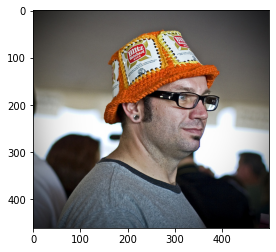

In [73]:
for i in range(1, 6):
  generate_caption(i, unq_train_imgs.iloc[4]['image'])

Actual Caption : 
['A little girl in pink climbs a rope bridge at the park .', 'The small child climbs on a red ropes on a playground .', 'A small child grips onto the red ropes at the playground .', 'A little girl climbing on red roping .', 'A child playing on a rope net .']


Predicted caption : 
little boy in red and red shirt is playing on red jungle gym .
Actual Caption : 
['A little girl in pink climbs a rope bridge at the park .', 'The small child climbs on a red ropes on a playground .', 'A small child grips onto the red ropes at the playground .', 'A little girl climbing on red roping .', 'A child playing on a rope net .']


Predicted caption : 
the small boy is sitting on the playground equipment with the red and red and red rope .
Actual Caption : 
['A little girl in pink climbs a rope bridge at the park .', 'The small child climbs on a red ropes on a playground .', 'A small child grips onto the red ropes at the playground .', 'A little girl climbing on red roping .', 'A chi

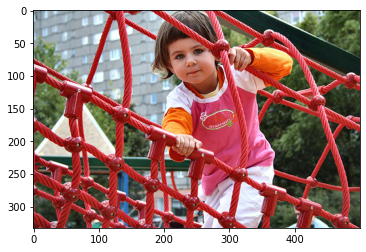

In [74]:
for i in range(1, 6):
  generate_caption(i, unq_train_imgs.iloc[5]['image'])